In [120]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
import tensorflow.keras.backend as kb
tfd = tfp.distributions

seed = 1
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 80

In [121]:
def build_kernel_matrix(num_datapoints, input_datapoints, kernel_fn, input_rhs):
    """
    Constructs the full kernel matrix element by element
    :return: tf.Tensor, (num_points, num_points)
    """
    kernel_mat = tf.Variable(tf.zeros((num_datapoints, num_datapoints), dtype=tf.float32))

    for i in range(num_datapoints):
        for j in range(i, num_datapoints):
            inputs_i = tf.expand_dims(tf.constant(input_datapoints[i]), 0)  # (1, d)
            inputs_j = tf.expand_dims(tf.constant(input_datapoints[j]), 0)  # (1, d)
            print('inputs: {}'.format(inputs_i.shape))
            with tf.GradientTape() as tape1:
                tape1.watch(inputs_i)
                with tf.GradientTape() as tape2:
                    tape2.watch(inputs_j)
                    kernel_output = kernel_fn.apply(tf.expand_dims(inputs_i, 0), tf.expand_dims(inputs_j, 0))  # (1, 1, 1)
                    # kernel_output = kernel_fn(tf.expand_dims(inputs_i, 0), tf.expand_dims(inputs_j, 0))  # (1, 1, 1)
                    kernel_output = tf.squeeze(kernel_output)  # scalar
                    print('kernel output: {}'.format(kernel_output))
                grads2 = tape2.gradient(kernel_output, inputs_j)  # (d,)
                print(grads2)
                first_inner_product = tf.reduce_sum(grads2 * input_rhs[j])  # scalar
                print(first_inner_product)
            grads1 = tape1.gradient(first_inner_product, inputs_i)  # (d,) # this becomes nan when taking gradient of value 0 (when x=y)
            # grads1 = tf.where(tf.math.is_nan(grads1), tf.zeros_like(grads1), grads1) 
            second_inner_product = tf.reduce_sum(grads1 * input_rhs[i])  # scalar
            kernel_mat[i, j].assign(second_inner_product)
            if i != j:
                kernel_mat[j, i].assign(second_inner_product)
    # kernel_mat = tf.where(tf.math.is_nan(kernel_mat), tf.ones_like(kernel_mat), kernel_mat) 
    K = tf.constant(kernel_mat.numpy())
    return K

In [122]:
def build_lyapunov_function2(xs, a, num_datapoints, input_datapoints, kernel_fn, input_rhs):
    mat = tf.Variable(tf.zeros((num_datapoints,), dtype=tf.float32))
    all_s = tf.Variable(tf.zeros((xs.shape[0],), dtype=tf.float32))
    for i in range(xs.shape[0]):
        for j in range(num_datapoints):
            inputs_i = tf.expand_dims(tf.constant(xs[i]), 0)  # (1, d)
            inputs_j = tf.expand_dims(tf.constant(input_datapoints[j]), 0)  # (1, d)
            # print(inputs_i.shape)
            with tf.GradientTape() as tape:
                tape.watch(inputs_j)
                kernel_output = kernel_fn.apply(tf.expand_dims(inputs_i, 0), tf.expand_dims(inputs_j, 0))  # (1, 1, 1)
                # kernel_output = kernel_fn(tf.expand_dims(inputs_i, 0), tf.expand_dims(inputs_j, 0))  # (1, 1, 1)
                
                # print(kernel_output.shape)
                kernel_output = tf.squeeze(kernel_output)  # scalar
            grads = tape.gradient(kernel_output, inputs_j)  # (d,)
            inner_product = tf.reduce_sum(grads * input_rhs[j])  # scalar
            mat[j].assign(inner_product)
        all_lambda = tf.constant(mat.numpy()) # (num_datapoints,)
        s = tf.reduce_sum(a * all_lambda) # scalar
        all_s[i].assign(s)
    solution = tf.constant(all_s.numpy()) # (len(x),)
    return solution

In [123]:
# def build_lyapunov_function(x, a, num_datapoints, input_datapoints, kernel_fn, input_rhs):
#     all_s = tf.Variable(tf.zeros((num_datapoints,), dtype=tf.float32))
#     for i in range(num_datapoints):
#         inputs_i = tf.expand_dims(tf.constant(input_datapoints[i]), 0)  # (1, d)
#         with tf.GradientTape() as tape:
#             tape.watch(inputs_i)
#             kernel_output = kernel_fn.apply(tf.expand_dims(x, 0), tf.expand_dims(inputs_i, 0))  # (1, 1, 1)
#             kernel_output = tf.squeeze(kernel_output)  # scalar
#         grads = tape.gradient(kernel_output, inputs_i)  # (d,)
#         inner_product = tf.reduce_sum(grads * input_rhs[i]) # scalar
#         all_s[i].assign(inner_product)
#     s = tf.reduce_sum(a * all_s)
#     return s

In [124]:
def safe_norm(x, epsilon=1e-12, axis=None):
  return tf.sqrt(tf.reduce_sum(x ** 2, axis=axis) + epsilon)

def Gaussian_Kernel(x, y):
    # print((tf.norm(x-y, ord = 2, axis=2)).shape)
    exponent = - 1/2 * tf.square(tf.norm(x-y, ord = 'euclidean', axis=0))
    # print(exponent)
    # exponent = - 1/2 * tf.square(safe_norm(x-y, axis=2))
    # print(exponent.shape)
    kernel = tf.expand_dims(tf.exp(exponent), 0)
    # kernel = tf.where(tf.math.is_nan(kernel), tf.ones_like(kernel), kernel) 
    return kernel

In [125]:
tf.squeeze(tf.ones((1,2)))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>

In [126]:
Gaussian_Kernel(data_points[0][tf.newaxis, tf.newaxis, ...], data_points[0][tf.newaxis, tf.newaxis, ...])

<tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[1., 1.]]], dtype=float32)>

In [127]:
g_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
n_y = 90
dim = 2
bounds = [1.6, 4]
# bounds = [2,2]
omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],n_y), 
                            np.random.uniform(-bounds[1],bounds[1],n_y)]).T

x = np.linspace(-bounds[0], bounds[0], n_y)
y = np.linspace(-bounds[1], bounds[1], n_y)

data_points = tf.transpose(tf.constant(np.array([x,y]), tf.float32))
                   


# van poole equation
def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return y

# def vf(x):
#     y1s = []
#     y2s = []
#     for i in x[:,0]:
#         if i != 0:
#             y1 = - i**2*dim / np.sin(i)
#         else:
#             y1 = 0.
#         y1s.append(y1)
#     for i in x[:,1]:
#         if i != 0:
#             y2 = - i**2*dim / np.sin(i)
#         else:
#             y2 = 0.
#         y2s.append(y2)
#     return [y1s, y2s]



# data_points = tf.constant(omega_domain, dtype=tf.float32)
input_RHS =  tf.transpose(tf.convert_to_tensor(vf(data_points), dtype=tf.float32))


beta = -tf.square(tf.norm(data_points, ord = 2, axis=1))[..., tf.newaxis]
A = build_kernel_matrix(n_y, data_points, g_kernel, input_RHS)

alphas = tf.linalg.solve(A, beta)

inputs: (1, 2)
kernel output: 1.0
tf.Tensor([[0. 0.]], shape=(1, 2), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
inputs: (1, 2)
kernel output: 0.9953246712684631
tf.Tensor([[-0.03578697 -0.08946736]], shape=(1, 2), dtype=float32)
tf.Tensor(0.50593317, shape=(), dtype=float32)
inputs: (1, 2)
kernel output: 0.9814295172691345
tf.Tensor([[-0.07057474 -0.17643672]], shape=(1, 2), dtype=float32)
tf.Tensor(0.8998667, shape=(), dtype=float32)
inputs: (1, 2)
kernel output: 0.9587005972862244
tf.Tensor([[-0.10341045 -0.25852594]], shape=(1, 2), dtype=float32)
tf.Tensor(1.1827903, shape=(), dtype=float32)
inputs: (1, 2)
kernel output: 0.9277616739273071
tf.Tensor([[-0.13343094 -0.33357716]], shape=(1, 2), dtype=float32)
tf.Tensor(1.3606527, shape=(), dtype=float32)
inputs: (1, 2)
kernel output: 0.8894456624984741
tf.Tensor([[-0.15990041 -0.39975077]], shape=(1, 2), dtype=float32)
tf.Tensor(1.4435222, shape=(), dtype=float32)
inputs: (1, 2)
kernel output: 0.8447571992874146
tf.Tensor([

In [128]:
# for i in A:
#     print(i)
input_RHS
# data_points
# tf.square(tf.norm(data_points, ord = 2, axis=1))

<tf.Tensor: shape=(90, 2), dtype=float32, numpy=
array([[ 4.0000000e+00, -7.8400006e+00],
       [ 3.9101124e+00, -7.2189927e+00],
       [ 3.8202248e+00, -6.6283145e+00],
       [ 3.7303371e+00, -6.0672674e+00],
       [ 3.6404495e+00, -5.5351553e+00],
       [ 3.5505619e+00, -5.0312815e+00],
       [ 3.4606740e+00, -4.5549488e+00],
       [ 3.3707864e+00, -4.1054573e+00],
       [ 3.2808988e+00, -3.6821122e+00],
       [ 3.1910112e+00, -3.2842159e+00],
       [ 3.1011236e+00, -2.9110703e+00],
       [ 3.0112360e+00, -2.5619793e+00],
       [ 2.9213483e+00, -2.2362454e+00],
       [ 2.8314607e+00, -1.9331713e+00],
       [ 2.7415731e+00, -1.6520603e+00],
       [ 2.6516855e+00, -1.3922136e+00],
       [ 2.5617979e+00, -1.1529353e+00],
       [ 2.4719100e+00, -9.3352759e-01],
       [ 2.3820224e+00, -7.3329359e-01],
       [ 2.2921348e+00, -5.5153584e-01],
       [ 2.2022471e+00, -3.8755777e-01],
       [ 2.1123595e+00, -2.4066126e-01],
       [ 2.0224719e+00, -1.1014950e-01],
       [

In [129]:
trial_x = tf.constant([[-1.1, 4.1]], tf.float32)
# trial_x = tf.constant([[0, 0]], tf.float32)
approx = build_lyapunov_function2(trial_x, alphas, n_y, data_points, g_kernel, input_RHS)
approx

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([10652173.], dtype=float32)>

In [130]:
n_x = 20
x = np.linspace(-bounds[0], bounds[0], n_x)
y = np.linspace(-bounds[1], bounds[1], n_x)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((n_x**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;
# define vector field for plot
new_vf = np.reshape(np.array(vf(DT)), (dim, n_x, n_x))

In [131]:
# solution = np.empty((n_x**2,))


# for ind, i in enumerate(DT):
#     input_x = tf.constant([i], tf.float32)
#     solution[ind] = build_lyapunov_function(input_x, alphas, n_y, data_points, g_kernel, input_RHS)

In [132]:
solution = build_lyapunov_function2(tf.constant(DT, tf.float32), alphas, n_y, data_points, g_kernel, input_RHS)
solution.shape

TensorShape([400])

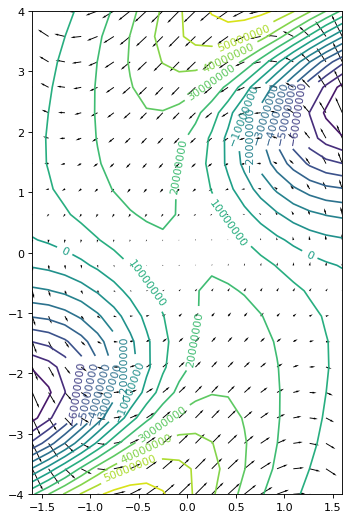

In [133]:
trial_solution = tf.reshape(solution, (n_x, n_x))
plt.figure(figsize=(5,8))
cp = plt.contour(x,y, trial_solution, levels=15)
plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=2, headlength=4)
plt.clabel(cp, inline=True, fontsize=10)
plt.show()

In [134]:
solution

<tf.Tensor: shape=(400,), dtype=float32, numpy=
array([ 18392808.  ,  30047520.  ,  41171408.  ,  50869888.  ,
        58389316.  ,  63213552.  ,  65120876.  ,  64193228.  ,
        60779040.  ,  55420904.  ,  48764336.  ,  41465708.  ,
        34114544.  ,  27180540.  ,  20988118.  ,  15716592.  ,
        11419352.  ,   8054118.5 ,   5516408.  ,   3670318.5 ,
       -19093848.  ,  -5780478.  ,   8259399.  ,  21908472.  ,
        34096336.  ,  43938124.  ,  50839492.  ,  54551240.  ,
        55167452.  ,  53073072.  ,  48855976.  ,  43203368.  ,
        36802432.  ,  30260552.  ,  24053984.  ,  18506632.  ,
        13794675.  ,   9969534.  ,   6990276.  ,   4757741.5 ,
       -57772364.  , -44760344.  , -29655236.  , -13636094.  ,
         2039176.  ,  16196920.  ,  27892196.  ,  36510064.  ,
        41809448.  ,  43907040.  ,  43211776.  ,  40327256.  ,
        35943940.  ,  30740308.  ,  25307172.  ,  20101986.  ,
        15432800.  ,  11466643.  ,   8253994.  ,   5760880.  ,
       